# Full Pipeline 1.0

This notebook is my first attempt at creating a full pipeline which segments and then classifies, providing a location in the image for each classified segment.

BorutaPy implementation was taken from [this](https://towardsdatascience.com/simple-example-using-boruta-feature-selection-in-python-8b96925d5d7a) reference. [Here](https://github.com/scikit-learn-contrib/boruta_py) is some supporting info.

The following is the basic idea of what I want to achieve in the first section of the code.

```
from sklearn.decomposition import PCA
from skimage import io, segmentation

# Load the hyperspectral image
image = io.imread('image.tif')

# Perform PCA to reduce the number of bands
pca = PCA(n_components=3)
image_pca = pca.fit_transform(image.reshape(-1, image.shape[2]))

# Apply SLIC superpixel segmentation
segments = segmentation.slic(image_pca, n_segments=100, compactness=10)

# Show the segmented image
io.imshow(segmentation.mark_boundaries(image_pca, segments))
io.show()
```

In [48]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns

from boruta import BorutaPy

from os.path import exists

from sklearn.decomposition import PCA

from skimage.segmentation import slic, mark_boundaries

from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestClassifier

## Loading Data

Here I'm going to use my pre-processed files containing reflectance values.

Given the fact that OpenHSI saves them in NetCDF format I'm using the `netCDF4` library to load them.

I'm also transposing the data array into a more comment layout.

In [104]:
fn = "processed-data/sardi-capture/capture-3/reflectance/2023_02_28/2023_02_28-01_03_28.nc"
fn_rad = "processed-data/sardi-capture/capture-3/radiance/2023_02_28/2023_02_28-01_03_28.nc"

gnd_t_fn = "right-pipe-gt.pkl"

In [50]:
# Load data
ds = nc.Dataset(fn)
ds_rad = nc.Dataset(fn_rad)

In [51]:
# extract the datacube from the dataset
dc = np.array(ds['datacube'])

In [52]:
# Data needs to be x, y, bands instead of bands, x, y.
data = dc.transpose(1,2,0)

In [53]:
# limit data to area of interest, so that gt lines up
# these values are taken from the gt-average notebook processing
# the x value cuts off the noise from the camera at the bottom of the image
# the y values center the pipe among all of the images
data = data[:430, 38:908, :]

In [54]:
# transform into a line of pixels for PCA
X = data.copy().reshape(data.shape[0]*data.shape[1],data.shape[2])

In [55]:
print(X.shape)

(374100, 131)


In [109]:
# Load ground truth
with open(gnd_t_fn, 'rb') as out_file:
    ground_truth = pickle.load(out_file)

In [110]:
y = ground_truth.copy().reshape(ground_truth.shape[0]*ground_truth.shape[1])  

In [111]:
print(y.shape)

(374100,)


## Useful Functions

In [59]:
def process_into_rgb(loc_ds):
    """
    Processes a given dataset into an rgb image for display
    """
    loc_dc = np.array(loc_ds['datacube'])
    loc_binned_wavelengths = np.array(loc_ds['wavelength'])
    loc_image = np.zeros((loc_dc.shape[1],loc_dc.shape[2],3), np.uint8)

    loc_red_wavelength = 620
    loc_green_wavelength = 560
    loc_blue_wavelength = 470

    loc_red_layer = loc_dc[np.argmin(np.abs(loc_binned_wavelengths-loc_red_wavelength)),:,:]  
    loc_green_layer = loc_dc[np.argmin(np.abs(loc_binned_wavelengths-loc_green_wavelength)),:,:] 
    loc_blue_layer = loc_dc[np.argmin(np.abs(loc_binned_wavelengths-loc_blue_wavelength)),:,:] 

    # loc_red_layer = loc_dc[120,:,:]  
    # loc_green_layer = loc_dc[80,:,:] 
    # loc_blue_layer = loc_dc[20,:,:] 

    loc_image[:,:,0] = loc_red_layer
    loc_image[:,:,1] = loc_green_layer
    loc_image[:,:,2] = loc_blue_layer

    # scale the values to within the central 2 to 98 percent values to remove outlier readings
    loc_vmax = np.nanpercentile(loc_image, 98)
    loc_vmin = np.nanpercentile(loc_image, 2)
    loc_image = ((loc_image.astype("f8") - loc_vmin) / (loc_vmax - loc_vmin)).astype("f4")
    loc_image = np.minimum(np.maximum(loc_image, 0), 1)

    loc_image *= 255
    loc_image = loc_image.astype(np.uint8)
    
    return loc_image

## Reducing Dimentionality

I'm just going to perform a simple PCA here to reduce the dimentionality of the image. I should be able to reduce the number of bands without distorting the spacial data and then apply the segmentation later to the original data, or an RGB representation, if I wish.

The first section of code is redundant and only there for sanity checking and illustrative purposes

### PCA

In [126]:
pca = PCA()

# fit my data, and transform
pcX = pca.fit_transform(X)

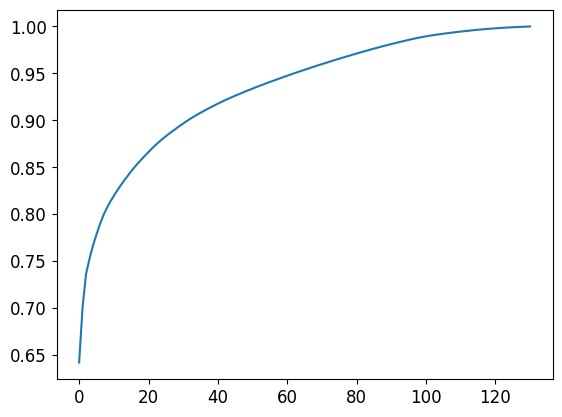

In [127]:
# graph the variance of each component (should give a good idea about the number of components to use).
ev = pca.explained_variance_ratio_
cumulativeVar = np.cumsum(ev)
plt.plot(cumulativeVar)

Now to actually perform the PCA.

In [137]:
# pick number of components that seems reasonable.
nComp = 20
pca = PCA(n_components=nComp)
pca.fit(X)
pcX = pca.transform(X)

In [138]:
# check the new dimensions
print(pcX.shape)

(374100, 20)


In [139]:
# reformat the image into the original shape
image_pca = pcX.reshape(data.shape[0], data.shape[1], pcX.shape[1])
print(image_pca.shape)

(430, 870, 20)


In [140]:
# let's have a look at the reduced image, if using 3 components
if image_pca.shape[2] == 3:
    plt.imshow(image_pca, 'gray')

### Boruta

In [20]:
# define random forest classifier
forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5, verbose=2)
forest.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   32.8s


building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished


RandomForestClassifier(class_weight='balanced', max_depth=5, n_jobs=-1,
                       verbose=2)

In [21]:
# define Boruta feature selection method
feat_selector = BorutaPy(forest, n_estimators=100, verbose=2, random_state=1, max_iter=10, )

In [22]:
# find all relevant features
feat_selector.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   53.0s


building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.5min finished


Iteration: 	1 / 10
Confirmed: 	0
Tentative: 	131
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   53.2s


building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100building tree 56 of 100

building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.4min finished


Iteration: 	2 / 10
Confirmed: 	0
Tentative: 	131
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   49.7s


building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.4min finished


Iteration: 	3 / 10
Confirmed: 	0
Tentative: 	131
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   53.0s


building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.5min finished


Iteration: 	4 / 10
Confirmed: 	0
Tentative: 	131
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   48.7s


building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished


Iteration: 	5 / 10
Confirmed: 	0
Tentative: 	131
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   44.0s


building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.1min finished


Iteration: 	6 / 10
Confirmed: 	0
Tentative: 	131
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100

building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   44.6s


building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished


Iteration: 	7 / 10
Confirmed: 	0
Tentative: 	131
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   45.5s


building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished


BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x7FA8896CEF40,
                                          verbose=2),
         max_iter=10, n_estimators=100,
         random_state=RandomState(MT19937) at 0x7FA8896CEF40, verbose=2)

In [23]:
# check selected features
feat_selector.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [24]:
# check ranking of features
feat_selector.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [25]:
# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(X)

In [26]:
feature_ranks = list(zip(feat_selector.ranking_, 
                         feat_selector.support_))

# iterate through and print out the results
for feat in feature_ranks:
    print('Rank: {},  Keep: {}'.format(feat[0], feat[1]))

Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Keep: True
Rank: 1,  Kee

In [27]:
# reformat the image into the original shape
image_pca = X_filtered.reshape(data.shape[0], data.shape[1], X_filtered.shape[1])
print(image_pca.shape)

(439, 1024, 131)


## Segmentation

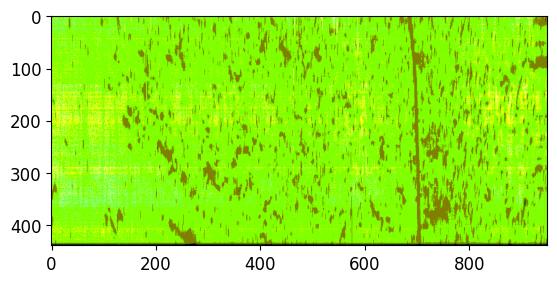

In [72]:
img = process_into_rgb(ds_rad)
plt.imshow(img)

In [73]:
img = img[:430, 38:908, :]

In [74]:
n_segments = int(round(img.shape[0]*img.shape[1]/100))
print(n_segments)

3741


In [75]:
# Apply SLIC superpixel segmentation
segments = slic(img, n_segments=n_segments, compactness=6, channel_axis=2)

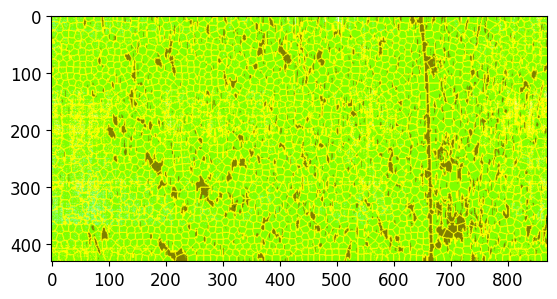

In [76]:
# Show the segmented image
plt.imshow(mark_boundaries(img.copy(), segments))

### Averaging over the segmentation

Skip to classification to just run on PCA data and not segmented data.

In [136]:
# recover the color channels of the image
# for the rgb image
red = img[:, :, 0]
green = img[:, :, 1]
blue = img[:, :, 2]

# for the pca/hsi image
pca_layers = []
for i in range(image_pca.shape[2]):
    pca_layers.append(image_pca[:,:,i])    

In [78]:
# retrieve the number of superpixels
nb_superpixels = np.max(segments) + 1

In [79]:
# assign the average color of each superpixel to the pixels belonging to it
# for the rgb image
for label in range(nb_superpixels):
    idx = segments == label
    red[idx] = np.mean(red[idx])
    green[idx] = np.mean(green[idx])
    blue[idx] = np.mean(blue[idx])

/home/solomon/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/solomon/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [80]:
# assign the average color of each superpixel to the pixels belonging to it
# for the HSI image
for label in range(nb_superpixels):
    idx = segments == label
    for i in range(len(pca_layers)):
        pca_layers[i][idx] = np.mean(pca_layers[i][idx])

/home/solomon/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [81]:
# draw the borders of the superpixels in black and white
img_seg = mark_boundaries(img.copy(), segments, color=(1, 1, 1), outline_color=(0, 0, 0), mode='outer')

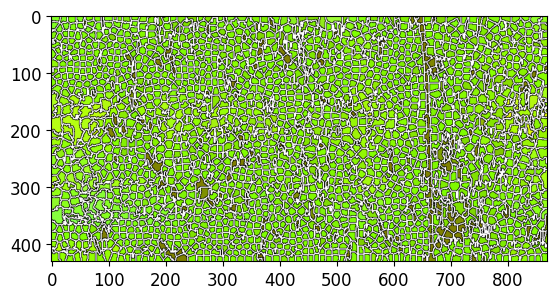

In [82]:
plt.imshow(img_seg)

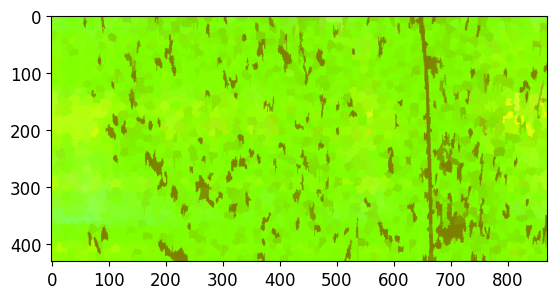

In [83]:
plt.imshow(img)

In [84]:
if image_pca.shape[2] == 3:
    plt.imshow(image_pca)

## Classification

In [208]:
# create our classifier
k_means = KMeans(n_clusters=4)

In [209]:
# classify 
k_fit = k_means.fit(X)
# k_fit = k_means.fit(pcX)
# k_fit = k_means.fit(X_filtered)

In [210]:
# capture clusers and labels
x_labels = k_means.labels_
x_cluster = x_labels.reshape(image_pca[:, :, 0].shape)

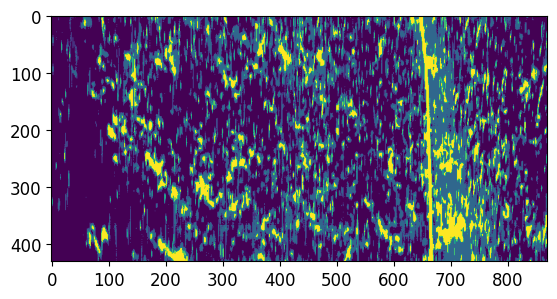

In [211]:
plt.imshow(x_cluster)

In [213]:
np.bincount(x_cluster.copy().reshape(x_cluster.shape[0]*x_cluster.shape[1]))

array([220407, 113248,    122,  40323])

In [214]:
for i in range(x_cluster.shape[0]):
    for j in range(x_cluster.shape[1]):
        if x_cluster[i,j] == 1:
            x_cluster[i,j] = 0

for i in range(x_cluster.shape[0]):
    for j in range(x_cluster.shape[1]):
        if x_cluster[i,j] == 2:
            x_cluster[i,j] = 0
            
for i in range(x_cluster.shape[0]):
    for j in range(x_cluster.shape[1]):
        if x_cluster[i,j] == 3:
            x_cluster[i,j] = 1

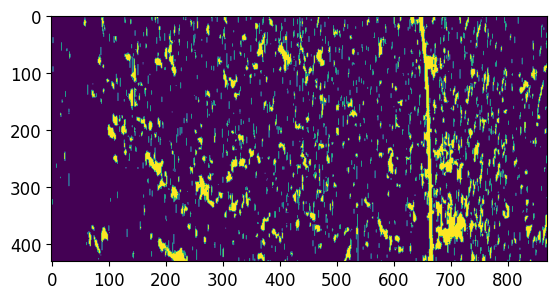

In [215]:
plt.imshow(x_cluster)

In [199]:
x_cluster = np.bitwise_not(x_cluster)

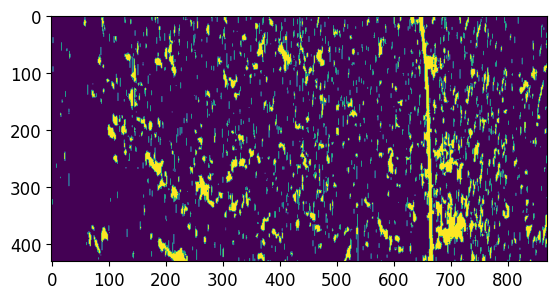

In [200]:
plt.imshow(x_cluster)

## Compare to ground truth

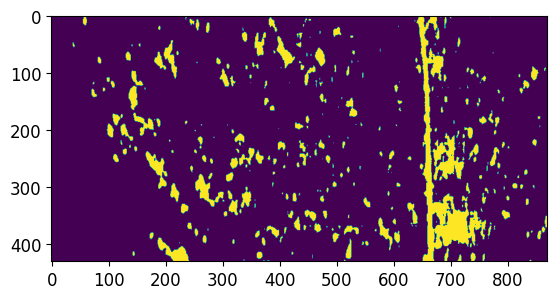

In [216]:
plt.imshow(ground_truth)

In [217]:
classified_data = x_cluster

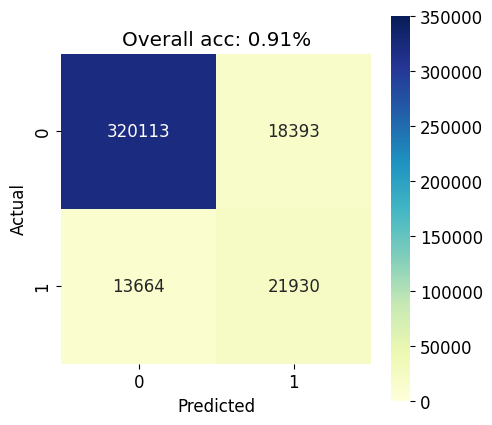

In [218]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import pandas as pd

classes = [0,1]

y_true = ground_truth.reshape(ground_truth.shape[0]*ground_truth.shape[1],1)
y_pred = classified_data.reshape(ground_truth.shape[0]*ground_truth.shape[1],1)
 
# multilabel_confusion_matrix(y_true, y_pred, *, sample_weight=None, labels=None, samplewise=False)
cm = confusion_matrix(y_true, y_pred, labels = classes)

df_cm = pd.DataFrame(cm, columns=classes, index=classes)

fig, ax1 = plt.subplots(1,1, figsize=(5,5))
plt.rcParams['font.size'] = 12

sns.heatmap(df_cm, annot=True, ax=ax1,square=True,  cmap="YlGnBu",vmin=0,vmax=350000,fmt='d')

ax1.set_title('Overall acc: {:.2f}%'.format(accuracy_score(y_true, y_pred)))
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual');

### Averaging over the segmentation

In [33]:
segments = int(round(img.shape[0]*img.shape[1]/1000))
print(segments)

285


In [34]:
# Apply SLIC superpixel segmentation
segments = slic(img, n_segments=segments, compactness=8, channel_axis=2)

In [35]:
# retrieve the number of superpixels
nb_superpixels = np.max(segments) + 1

In [36]:
# assign the average color of each superpixel to the pixels belonging to it
# for the rgb image
for label in range(nb_superpixels):
    idx = segments == label
    sub = x_cluster[idx].copy()
    if len(sub) > 0:
        x_cluster[idx] = np.argmax(np.bincount(sub))

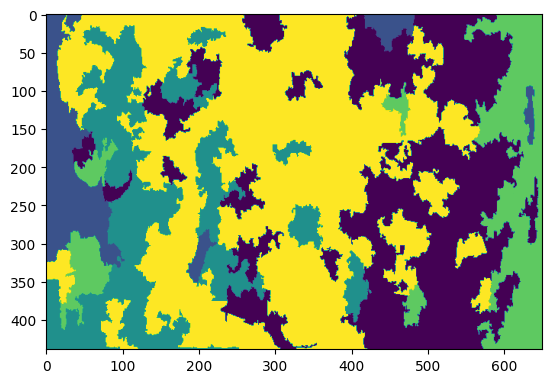

In [37]:
plt.imshow(x_cluster)